# Step 5: Dealing with non-stationary environments with two abrupt changes
Assume that all the properties of the graph are known except for the edge activation
probabilities. Assume that the edge activation probabilities are non-stationary, being subject
to seasonal phases (3 different phases spread over 365 days). Provide motivation for the
phases. Apply the greedy algorithm to the problem of maximizing the expected number of
activated customers, where each edge activation probability is replaced with its upper
confidence bound (in a UCB1-like fashion). Moreover, apply two non-stationary flavors of the
algorithm. The first one is passive and exploits a sliding window, while the second one is
active and exploits a change detection test. Provide a sensitivity analysis of the algorithms,
evaluating different values of the length of the sliding window in the first case and different
values for the parameters of the change detection test in the second case. Report the plots
of the average value and standard deviation of the cumulative regret, cumulative reward,
instantaneous regret, and instantaneous reward.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm
import random


## **Environments**

In [2]:

class Environment:
    def __init__(self, probabilities):
        self.probabilities = probabilities

    def round(self, pulled_arm):
        reward = np.random.binomial(1, self.probabilities[pulled_arm])
        return reward

In [3]:
import numpy as np
from tqdm import tqdm

def simulate_episode(init_prob_matrix, seeds:list, max_steps):
    prob_matrix=init_prob_matrix.copy()
    n_nodes=prob_matrix.shape[0]

    #set up seeds
    active_nodes=np.zeros(n_nodes)

    for seed in seeds:
        active_nodes[seed]=1

    history=np.array([active_nodes])

    newly_active_nodes=active_nodes

    t=0

    while (t<max_steps and np.sum(newly_active_nodes)>0):
        #retrieve probability of edge activations
        p = (prob_matrix.T*active_nodes).T
        activated_edges=p>np.random.rand(p.shape[0], p.shape[1])
        #remove activated edges
        prob_matrix=prob_matrix*((p!=0)==activated_edges)
        #update active nodes
        newly_active_nodes=(np.sum(activated_edges, axis=0)>0)*(1-active_nodes)
        #print(newly_active_nodes)
        active_nodes=np.array(active_nodes+newly_active_nodes)
        #print(active_nodes)
        history=np.concatenate((history, [newly_active_nodes]), axis=0)
        t+=1
    return history, active_nodes

def test_seed(seeds, prob_matrix, k, max_steps):
    reward = 0
    for i in range(k):
        history, active_nodes=simulate_episode(prob_matrix, seeds, max_steps)
        reward+=np.sum(active_nodes)
    return reward/k

def greedy_algorithm(init_prob_matrix, budget, k, max_steps):
    prob_matrix=init_prob_matrix.copy()
    n_nodes=prob_matrix.shape[0]

    seeds=[]
    for j in range(budget):
        rewards=np.zeros(n_nodes)

        for i in tqdm(range(n_nodes)):
            if i not in seeds:
                rewards[i]=test_seed([i]+seeds, prob_matrix, k, max_steps)
        seeds.append(np.argmax(rewards))


    return seeds

In [4]:
class NonStationaryEnvironment(Environment):
    def __init__(self, probabilities, horizon):
        super().__init__(probabilities)
        self.t=0
        n_phases = len(self.probabilities)
        self.phase_size = horizon / n_phases

    def round(self, pulled_arm):
        current_phase = int(self.t / self.phase_size)
        p = self.probabilities[current_phase][pulled_arm]
        reward = np.random.binomial(1, p)
        self.t += 1
        return reward

## Learners

In [5]:

class Learner:

    def __init__(self, n_arms) -> None:
        self.n_arms = n_arms
        self.t = 0
        self.rewards_per_arm = x = [[] for i in range(n_arms)]
        self.collected_rewards = np.array([])

    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards = np.append(self.collected_rewards, reward)
        self.t += 1

In [6]:
class UCBLearner(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.n_pulls = np.zeros(n_arms)  # count the number of times each arm has been pulled
        self.confidence = np.array([np.inf] * n_arms)

    def pull_arm(self):
        upper_confidence_bound = self.empirical_means + self.confidence
        return np.random.choice(np.where(upper_confidence_bound == upper_confidence_bound.max())[0])

    def update(self, pulled_arm, reward):
        self.t += 1
        self.n_pulls[pulled_arm] += 1
        self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm] * (self.n_pulls[pulled_arm] - 1) + reward) / self.n_pulls[pulled_arm]
        for a in range(self.n_arms):
            #n_samples = max(1, self.n_pulls[a])
            n_samples = self.n_pulls[a]
            self.confidence[a] = np.sqrt(2 * np.log(self.t) / n_samples) if n_samples > 0 else np.inf

        self.update_observations(pulled_arm, reward)

In [7]:
class SW_UCBLearner(UCBLearner):
    def __init__(self, n_arms, window_size):
        super().__init__(n_arms)
        self.window_size = window_size
        # array showing sequence of pulled arms
        self.pulled_arms = np.array([])



    # get the list of unplayed arm in the last time_window
    def get_unplayed_arms(self, pulled_arms, time_window):
      all_arms = [i for i in range(self.n_arms)]
      if len(pulled_arms) < time_window:
        return list(all_arms)
      else:
        last_time_window = pulled_arms[-time_window:]
        played_arms = set(last_time_window)
        all_arms = [i for i in range(self.n_arms)]
        unplayed_arms = set(all_arms) - played_arms
        return list(unplayed_arms)


    def pull_arm(self):
        upper_confidence_bound = self.empirical_means + self.confidence

        self.upper_confidence_bound = upper_confidence_bound

        arms = [i for i in range(n_arms)] # get a list of all arms
        unplayed_arms_in_window = self.get_unplayed_arms(self.pulled_arms, self.window_size)
        # if there are unplayed arms in the most recent time window, play one of them at random
        if unplayed_arms_in_window != []:
            return random.choice(unplayed_arms_in_window)
        # else play the one with highest confidence bound
        else:
            return np.random.choice(np.where(upper_confidence_bound == upper_confidence_bound.max())[0])

    def update(self, pulled_arm, reward):
        self.t += 1
        self.pulled_arms = np.append(self.pulled_arms, pulled_arm)

        for arm in range(self.n_arms):
            # count the number of times the arm has been played in the window
            n_samples = np.count_nonzero(np.array(self.pulled_arms[-window_size:]) == arm)
            # get the cumulative reward for the window if the arm was played at least once in the window
            cum_reward_in_window = np.sum(self.rewards_per_arm[arm][-n_samples:]) if n_samples > 0 else 0
            # empirical mean is computed
            self.empirical_means[arm] = cum_reward_in_window / n_samples if n_samples > 0 else 0
            # confidence decreasing linearly with number of samples in window
            self.confidence[arm] = np.sqrt(2 * np.log(self.t) / n_samples) if n_samples > 0 else 1000

        self.update_observations(pulled_arm, reward)

    def expectations(self):
        return self.empirical_means


In [8]:
class CUSUM:
  def __init__(self, M, eps, h):
    self.M = M #Length of window considered by CD
    self.eps = eps #Epsylon
    self.h = h #Threshold
    self.t = 0
    self.reference = 0 #Reference Mean
    self.g_plus = 0
    self.g_minus = 0

  def update(self, sample):
    self.t += 1


    # If time < CD window, update reference mean with new sample and return 0
    if self.t <= self.M:
      self.reference += sample/self.M
      return 0

    # If time > CD window, compute deviations and their cumulative sum
    else:
      s_plus = (sample - self.reference) - self.eps
      s_minus = -(sample - self.reference) - self.eps
      self.g_plus = max(0, self.g_plus + s_plus)
      self.g_minus = max(0, self.g_minus+ s_minus)
      # Return 1 if cusum of deviations are over threshold h
      return self.g_plus > self.h or self.g_minus > self.h

  def reset(self):
    # Reset the parameters if a detection occurs
    self.t = 0
    self.g_minus = 0
    self.g_plus = 0

  def Rounds_After_Last_Change(self):
    return self.t

In [9]:
class CUSUMUCB(UCBLearner):
    def __init__(self, n_arms, M=10, eps=0.01, h=5, alpha=0.1):
        super().__init__(n_arms)
        self.change_detection = [CUSUM(M, eps, h) for _ in range(n_arms)] #List of CUSUM objects
        self.detections = [[] for _ in range(n_arms)] # List of lists of detections per arm
        self.alpha = alpha
        self.pulled_arms = np.array([])
        # Initialize tau(a) as 0 for all arms.
        self.window_sizes = [0 for i in range(n_arms)]


    def pull_arm(self):
      upper_confidence_bound = self.empirical_means + self.confidence
      upper_confidence_bound[np.isinf(upper_confidence_bound)] = 1e3

      if np.random.binomial(1,1-self.alpha):
        return np.random.choice(np.where(upper_confidence_bound == upper_confidence_bound.max())[0])
      else:
        return random.randint(0,n_arms-1)




    def update(self, pulled_arm, reward):
      self.t += 1
      self.pulled_arms = np.append(self.pulled_arms, pulled_arm)

              # Update the change detection for the arm pulled
      if self.change_detection[pulled_arm].update(reward):
        self.change_detection[pulled_arm].reset()


      for arm in range(self.n_arms):
        # update window_sizes for each arm
        self.window_sizes[arm] = self.change_detection[arm].Rounds_After_Last_Change()
        # count the number of times the arm has been played in the window
        n_samples = np.count_nonzero(np.array(self.pulled_arms[-self.window_sizes[arm]:]) == arm)
        # get the cumulative reward for the window if the arm was played at least once in the window
        cum_reward_in_window = np.sum(self.rewards_per_arm[arm][-n_samples:]) if n_samples > 0 else 0
        # empirical mean is computed
        self.empirical_means[arm] = cum_reward_in_window / n_samples if n_samples > 0 else 0
        # confidence decreasing linearly with number of samples in window
        self.confidence[arm] = np.sqrt(2 * np.log(self.t) / n_samples) if n_samples > 0 else 1000


      self.update_observations(pulled_arm, reward)

    def expectations(self):
      return self.empirical_means

## Clairvoyant

In [10]:
def hungarian_algorithm(matrix):
    m = matrix.copy()
    n_rows, n_cols = m.shape
    max_val = np.max(m)

    if n_rows > n_cols:
        m = np.pad(m, ((0, 0), (0, n_rows - n_cols)), mode='constant', constant_values=max_val)
    elif n_cols > n_rows:
        m = np.pad(m, ((0, n_cols - n_rows), (0, 0)), mode='constant', constant_values=max_val)

    assigned_rows, assigned_cols = linear_sum_assignment(m)

    assignment = np.zeros_like(m, dtype=int)
    assignment[assigned_rows, assigned_cols] = 1

    return assignment[:n_rows, :n_cols] * matrix, assignment[:n_rows, :n_cols]

def generate_reward(mean, std_dev):
    return lambda: np.random.normal(mean, std_dev)

In [11]:
def hungarian_algorithm(matrix):
    m = matrix.copy()
    n_rows, n_cols = m.shape
    max_val = np.max(m)

    if n_rows > n_cols:
        m = np.pad(m, ((0, 0), (0, n_rows - n_cols)), mode='constant', constant_values=max_val)
    elif n_cols > n_rows:
        m = np.pad(m, ((0, n_cols - n_rows), (0, 0)), mode='constant', constant_values=max_val)

    assigned_rows, assigned_cols = linear_sum_assignment(m)

    assignment = np.zeros_like(m, dtype=int)
    assignment[assigned_rows, assigned_cols] = 1

    return assignment[:n_rows, :n_cols] * matrix, assignment[:n_rows, :n_cols]

def generate_reward(mean, std_dev):
    return lambda: np.random.normal(mean, std_dev)



def get_reward(node_class, product_class, rewards_parameters):
    return np.random.normal(rewards_parameters[0][node_class, product_class], rewards_parameters[1][node_class, product_class])

def clairvoyant(graph_probabilities, true_prob, customer_assignments, rewards_parameters, real_reward_parameters, n_exp, seeds=None):
    hungarian_matrix = hungarian_algorithm(rewards_parameters[0])[1]

    reward_per_experiment = [[] for i in range(n_exp)]

    if seeds == None:
        opt_seeds = greedy_algorithm(graph_probabilities, 1, 100, 100)
    else:
        opt_seeds = seeds

    for e in tqdm(range(n_exp)):

        history = simulate_episode(true_prob, opt_seeds, 10)[0]
        activation_flow = np.concatenate([np.where(row == 1)[0] for row in history]).tolist()
        class_activation_flow = customer_assignments[activation_flow]
        exp_reward = 0

        units = [3, 3, 3]

        while units > [0, 0, 0]:

            for customer in class_activation_flow:

                # Find mean of matching reward
                nonzero_index = np.nonzero(hungarian_matrix[customer])
                product_class = int(nonzero_index[0][0])

                if units[product_class] != 0:
                    reward = get_reward(customer, product_class, real_reward_parameters)
                    units[product_class] = units[product_class] - 1

                else:
                    instock_units = [index for index, value in enumerate(units) if value != 0]
                    if instock_units:  # Check if instock_units is not empty before choosing
                        product_class = random.choice(instock_units)
                        reward = get_reward(customer, product_class, real_reward_parameters)
                        units[product_class] -= 1
                    else:
                        # Handle the case when units is empty (no available units)
                        reward = 0

                exp_reward = exp_reward + reward

            reward_per_experiment[e] = exp_reward

    return np.mean(reward_per_experiment), np.std(reward_per_experiment)


import numpy as np
from tqdm import tqdm

def simulate_episode(init_prob_matrix, seeds:list, max_steps):
    prob_matrix=init_prob_matrix.copy()
    n_nodes=prob_matrix.shape[0]

    #set up seeds
    active_nodes=np.zeros(n_nodes)

    for seed in seeds:
        active_nodes[seed]=1

    history=np.array([active_nodes])

    newly_active_nodes=active_nodes

    t=0

    while (t<max_steps and np.sum(newly_active_nodes)>0):
        #retrieve probability of edge activations
        p = (prob_matrix.T*active_nodes).T
        activated_edges=p>np.random.rand(p.shape[0], p.shape[1])
        #remove activated edges
        prob_matrix=prob_matrix*((p!=0)==activated_edges)
        #update active nodes
        newly_active_nodes=(np.sum(activated_edges, axis=0)>0)*(1-active_nodes)
        #print(newly_active_nodes)
        active_nodes=np.array(active_nodes+newly_active_nodes)
        #print(active_nodes)
        history=np.concatenate((history, [newly_active_nodes]), axis=0)
        t+=1
    return history, active_nodes

def test_seed(seeds, prob_matrix, k, max_steps):
    reward = 0
    for i in range(k):
        history, active_nodes=simulate_episode(prob_matrix, seeds, max_steps)
        reward+=np.sum(active_nodes)
    return reward/k

def greedy_algorithm(init_prob_matrix, budget, k, max_steps):
    prob_matrix=init_prob_matrix.copy()
    n_nodes=prob_matrix.shape[0]

    seeds=[]
    for j in range(budget):
        rewards=np.zeros(n_nodes)

        for i in tqdm(range(n_nodes)):
            if i not in seeds:
                rewards[i]=test_seed([i]+seeds, prob_matrix, k, max_steps)
        seeds.append(np.argmax(rewards))

    return seeds

## SCENARIO SET UP

#### Classes of product and Classes of customers

In [323]:
node_classes = 3
product_classes = 3
products_per_class = 3

means = np.random.uniform(10, 20, (3,3))
std_dev = np.ones((3,3))
rewards_parameters = (means, std_dev)

#### Probability tables (True Values) for each phase

In [207]:
n_arms = 30
n_phases = 3,
T = 365
window_size = int(T/10)
n_experiments = 10


def generate_graph_probabilities(n_nodes, edge_rate):
    graph_structure = np.random.binomial(1, edge_rate, (n_nodes, n_nodes))
    graph_probabilities = np.random.uniform(0, 1, (n_nodes, n_nodes)) * graph_structure
    return graph_probabilities


n_nodes = 30
edge_rate = 0.07
n_phases = 3

prob_phase1 = np.reshape(generate_graph_probabilities(n_nodes=n_nodes,edge_rate=edge_rate),(30,30))
prob_phase2 = np.reshape(generate_graph_probabilities(n_nodes=n_nodes,edge_rate=edge_rate),(30,30))
prob_phase3 = np.reshape(generate_graph_probabilities(n_nodes=n_nodes,edge_rate=edge_rate),(30,30))

# array containing three (30*30) different probabilities tables.
p = np.stack((prob_phase1, prob_phase2, prob_phase3), axis=0)

# Array K will contain 30 arrays containing each 3 rows: row[i] of probability table of phase1, row[i] of the one of phase2, row[i] of the one of phase3.
K = np.array([p[:, i] for i in range(p.shape[1])])


In [324]:
customer_assignments = np.random.choice([0,1,2], size=30)


## Probability Estimators

In [210]:
def SW_Generate_Probability_Estimates(p, n_arms=n_arms, n_phases=n_phases, T=T, window_size=window_size, n_experiments=n_experiments):
    phases_len = int(T / n_phases)
    swucb_rewards_per_experiment = []

    experimentS_means_at_each_round = np.empty((n_experiments, T, n_arms))

    for e in tqdm(range(0, n_experiments)):
        # Initialize environment
        swucb_env = NonStationaryEnvironment(probabilities=p, horizon=T)
        # Initialize learner
        swucb_learner = SW_UCBLearner(n_arms=n_arms, window_size=window_size)

        for t in range(0, T):
            # SW-UCB Learner
            pulled_arm = swucb_learner.pull_arm()
            reward = swucb_env.round(pulled_arm)
            swucb_learner.update(pulled_arm, reward)

            # At each round memorize a copy of the means of each arm
            expected_rew = swucb_learner.expectations()
            experimentS_means_at_each_round[e, t] = expected_rew.copy()

    return experimentS_means_at_each_round

In [211]:

def CUSUM_Generate_Probability_Estimates(p, n_arms=n_arms, n_phases=n_phases, T=T, n_experiments=n_experiments):
    phases_len = int(T / n_phases)
    cusum_rewards_per_experiment = []

    experimentS_means_at_each_round = np.empty((n_experiments, T, n_arms))

    for e in tqdm(range(0, n_experiments)):
        # Initialize environment
        cusum_env = NonStationaryEnvironment(probabilities=p, horizon=T)
        # Initialize learner
        cusum_learner = CUSUMUCB(n_arms=n_arms, M=1, eps=0.1, h=0.3, alpha=0.2)

        for t in range(0, T):
            # SW-UCB Learner
            pulled_arm = cusum_learner.pull_arm()
            reward = cusum_env.round(pulled_arm)
            cusum_learner.update(pulled_arm, reward)

            # At each round memorize a copy of the means of each arm
            expected_rew = cusum_learner.expectations()
            experimentS_means_at_each_round[e, t] = expected_rew.copy()

    return experimentS_means_at_each_round

#### Estimating edges' probabilities with SW


In [213]:
SW_rounds_probabilities_for_each_arm = []

for index in range(len(K)):

  print("Learning for row:",index)
  estimates = SW_Generate_Probability_Estimates(K[index], n_experiments = 5)
  SW_rounds_probabilities_for_each_arm.append(estimates)

SW_rounds_probabilities_for_each_arm = np.mean(SW_rounds_probabilities_for_each_arm, axis=1)

Learning for row: 0


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.50it/s]


Learning for row: 1


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.48it/s]


Learning for row: 2


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.52it/s]


Learning for row: 3


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Learning for row: 4


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Learning for row: 5


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.69it/s]


Learning for row: 6


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.75it/s]


Learning for row: 7


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.73it/s]


Learning for row: 8


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.79it/s]


Learning for row: 9


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.53it/s]


Learning for row: 10


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.62it/s]


Learning for row: 11


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.46it/s]


Learning for row: 12


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.44it/s]


Learning for row: 13


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.60it/s]


Learning for row: 14


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.73it/s]


Learning for row: 15


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.68it/s]


Learning for row: 16


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.55it/s]


Learning for row: 17


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]


Learning for row: 18


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.74it/s]


Learning for row: 19


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.56it/s]


Learning for row: 20


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]


Learning for row: 21


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.69it/s]


Learning for row: 22


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Learning for row: 23


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.46it/s]


Learning for row: 24


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


Learning for row: 25


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.66it/s]


Learning for row: 26


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.68it/s]


Learning for row: 27


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.35it/s]


Learning for row: 28


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


Learning for row: 29


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


In [214]:
CUSUM_rounds_probabilities_for_each_arm = []

for index in range(len(K)):

  print("Learning for row:",index)
  estimates = CUSUM_Generate_Probability_Estimates(K[index], n_experiments = 5)
  CUSUM_rounds_probabilities_for_each_arm.append(estimates)

CUSUM_rounds_probabilities_for_each_arm = np.mean(CUSUM_rounds_probabilities_for_each_arm, axis=1)

Learning for row: 0


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


Learning for row: 1


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


Learning for row: 2


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


Learning for row: 3


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.03it/s]


Learning for row: 4


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


Learning for row: 5


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


Learning for row: 6


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


Learning for row: 7


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


Learning for row: 8


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


Learning for row: 9


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


Learning for row: 10


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


Learning for row: 11


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


Learning for row: 12


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


Learning for row: 13


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


Learning for row: 14


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


Learning for row: 15


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


Learning for row: 16


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


Learning for row: 17


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


Learning for row: 18


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


Learning for row: 19


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


Learning for row: 20


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


Learning for row: 21


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.89it/s]


Learning for row: 22


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


Learning for row: 23


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


Learning for row: 24


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


Learning for row: 25


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


Learning for row: 26


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


Learning for row: 27


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


Learning for row: 28


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


Learning for row: 29


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


In [215]:

def Reshape(LIST):
  # Convert the lists into a NumPy array
  array_of_lists = np.array(LIST)
  # Transpose the array to swap the axes
  transposed_array = array_of_lists.T
  # Split the transposed array into separate arrays along axis=1
  return np.split(transposed_array, transposed_array.shape[1], axis=1)


In [216]:
estimated_tables_SW = Reshape(SW_rounds_probabilities_for_each_arm)
estimated_tables_CUSUM = Reshape(CUSUM_rounds_probabilities_for_each_arm)

In [217]:
phases_array = np.empty((T, n_nodes, n_nodes))
T = 365
phases_len = int(T / n_phases)

# Loop through each time step and assign the corresponding phase probability array
for t in range(T):
    if t <= 121:
        phases_array[t] = p[0]
    if t in range(121, 243):
        phases_array[t] = p[1]
    if t >=243:
        phases_array[t] = p[2]


#### Instantaneous rewards in edge activation probability estimation

In [218]:
SW_reward = [np.sum(i) for i in estimated_tables_SW]
CUSUM_reward = [np.sum(i) for i in estimated_tables_CUSUM]
Clairv = [np.sum(i) for i in phases_array]

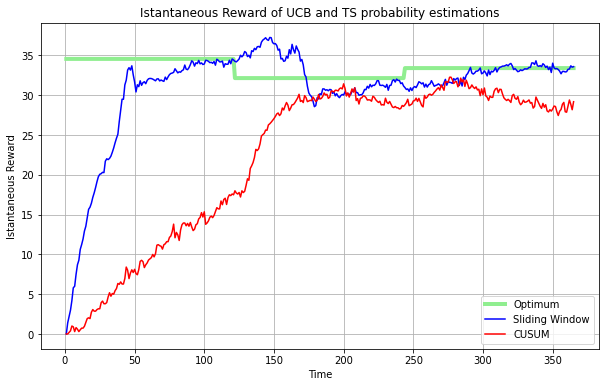

In [219]:
time_periods = range(1, 366)
plt.figure(figsize=(10, 6))
plt.plot(time_periods, Clairv, color='lightgreen', linestyle='-', label='Optimum', linewidth=4)
plt.plot(time_periods, SW_reward, color='blue', linestyle='-', label='Sliding Window')
plt.plot(time_periods, CUSUM_reward, color='red', linestyle='-', label='CUSUM')
plt.xlabel('Time')
plt.ylabel('Istantaneous Reward')
plt.title('Istantaneous Reward of UCB and TS probability estimations')
plt.legend()
plt.grid()
plt.show()

#### Regret in activation probability estimation

In [220]:
estimated_tables_SW = np.array(estimated_tables_SW)
estimated_tables_CUSUM = np.array(estimated_tables_CUSUM)

original_shape = estimated_tables_SW.shape
estimated_tables_SW = estimated_tables_SW.reshape(original_shape[0], original_shape[1], original_shape[3])
estimated_tables_CUSUM = estimated_tables_CUSUM.reshape(original_shape[0], original_shape[1], original_shape[3])

SW_regret = np.sum((phases_array - estimated_tables_SW),axis=(1,2))
CUSUM_regret = np.sum((phases_array - estimated_tables_CUSUM),axis=(1,2))
SW_cumulative_regret = np.cumsum(SW_regret)
CUSUM_cumulative_regret = np.cumsum(CUSUM_regret)


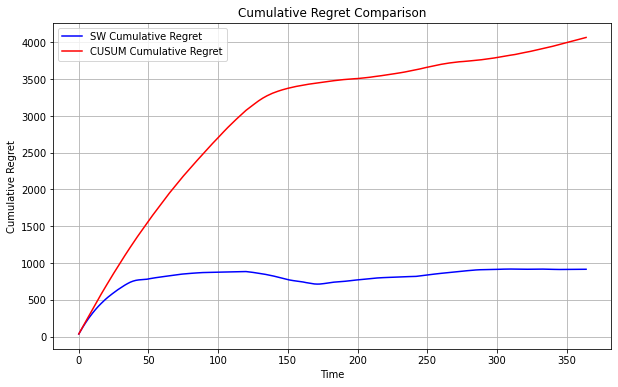

In [221]:
plt.figure(figsize=(10, 6))
plt.plot(SW_cumulative_regret, label='SW Cumulative Regret', color="blue")
plt.plot(CUSUM_cumulative_regret, label='CUSUM Cumulative Regret', color = "red")

plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret Comparison')
plt.legend()
plt.grid()
plt.show()

### COMPUTING REWARDS

### Reward - SW_UCB

In [338]:
n_exp = 10

SW_mean_rewards_per_round = []
SW_std_dev_rewards_per_round = []
for table in tqdm(range(len(estimated_tables_SW))):
    true_p = phases_array[table]
    table = np.reshape(estimated_tables_SW[table],(30,30))
    clairvoyant_output = clairvoyant(table, true_p, customer_assignments, rewards_parameters, rewards_parameters, n_exp=10)
    SW_mean_rewards_per_round.append(clairvoyant_output[0])
    SW_std_dev_rewards_per_round.append(clairvoyant_output[1])


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.11it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 117.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.59it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 121.10it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 105.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 94.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.80it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.49it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.21it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.74it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.73it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.69it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.00it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.00it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.90it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.85it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.97it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.89it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.54it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.69it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.87it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.66it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.35it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.50it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.91it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.08it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.04it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.84it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.79it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.64it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.03it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 365/365 [04:51<00:00,  1.25it/s]


### Reward - CUSUM_UCB

In [339]:
CUSUM_mean_rewards_per_round = []
CUSUM_std_dev_rewards_per_round = []
for table in tqdm(range(len(estimated_tables_CUSUM))):
    true_p = phases_array[table]
    table = np.reshape(estimated_tables_CUSUM[table],(30,30))
    clairvoyant_output = clairvoyant(table, true_p, customer_assignments, rewards_parameters, rewards_parameters, n_exp=10)
    CUSUM_mean_rewards_per_round.append(clairvoyant_output[0])
    CUSUM_std_dev_rewards_per_round.append(clairvoyant_output[1])


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.67it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 113.20it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 110.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.19it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.51it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 118.10it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 121.94it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.35it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 115.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.84it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 109.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.50it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 70.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.26it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.71it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 65.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 67.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.28it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.24it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.22it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.64it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.02it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.42it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.54it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.39it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.13it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.19it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.41it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.99it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.37it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.74it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.96it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.65it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.22it/s]

100%|███████████████████████████

In [345]:
optimum_means = []
for table in tqdm(p):
    attempts = []
    for i in tqdm(range(300)):
        z = clairvoyant(table, table, customer_assignments, rewards_parameters, rewards_parameters, n_exp=10)
        attempts.append(z[0])
    clairvoyant_output = max(attempts)
    for i in range(int(365 / n_phases)+1):
        optimum_means.append(clairvoyant_output)

optimum_means = optimum_means[:T]

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 13%|███████████                                                                        | 4/30 [00:00<00:00, 33.33it/s]

 27%|██████████████████████▏                                                            | 8/30 [00:00<00:00, 34.00it/s]

 40%|████████████████████████████████▊                                                 | 12/30 [00:00<00:00, 26.75it/s]

 50%|█████████████████████████████████████████                                         | 15/30 [00:00<00:00, 26.07it/s]

 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:00<00:00, 25.58it/s]

 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [00:00<00:00, 25.26it/s]

 80%|███████████████████████████

 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [00:00<00:00, 27.73it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:00<00:00, 26.10it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [00:01<00:00, 25.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.79it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 999.98it/s]

  4%|███▏                                                                             | 12/300 [00:13<05:25,  1.13s/it]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 17%|█████████████▊                                                                     | 5/30 [00:00<00:00, 28.90it/s]

 30%|████████████████████████▉ 

 53%|███████████████████████████████████████████▋                                      | 16/30 [00:00<00:00, 29.25it/s]

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:00<00:00, 25.13it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:00<00:00, 27.17it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [00:01<00:00, 25.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.50it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 909.26it/s]

  8%|██████▍                                                                          | 24/300 [00:26<05:10,  1.13s/it]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 17%|█████████████▊            

 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:00<00:00, 28.40it/s]

 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:00<00:00, 29.69it/s]

 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [00:00<00:00, 28.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.84it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 769.17it/s]

 12%|█████████▋                                                                       | 36/300 [00:40<05:01,  1.14s/it]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 17%|█████████████▊                                                                     | 5/30 [00:00<00:00, 46.30it/s]

 33%|██████████████████████████

 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:00<00:00, 29.63it/s]

 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [00:00<00:00, 28.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.07it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 833.39it/s]

 16%|████████████▉                                                                    | 48/300 [00:53<04:32,  1.08s/it]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 3/30 [00:00<00:00, 29.41it/s]

 20%|████████████████▌                                                                  | 6/30 [00:00<00:01, 23.46it/s]

 30%|████████████████████████▉ 

 47%|██████████████████████████████████████▎                                           | 14/30 [00:00<00:00, 31.19it/s]

 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:00<00:00, 30.10it/s]

 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:00<00:00, 29.41it/s]

 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [00:00<00:00, 28.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.01it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1249.64it/s]

 20%|████████████████▏                                                                | 60/300 [01:07<04:30,  1.13s/it]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 13%|███████████               

 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [00:00<00:00, 26.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.25it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1000.19it/s]

 24%|███████████████████▍                                                             | 72/300 [01:21<04:17,  1.13s/it]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 17%|█████████████▊                                                                     | 5/30 [00:00<00:00, 40.00it/s]

 30%|████████████████████████▉                                                          | 9/30 [00:00<00:00, 35.80it/s]

 43%|███████████████████████████████████▌                                              | 13/30 [00:00<00:00, 27.97it/s]

 53%|██████████████████████████

 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [00:00<00:00, 27.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.15it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

 28%|██████████████████████▋                                                          | 84/300 [01:34<04:01,  1.12s/it]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 13%|███████████                                                                        | 4/30 [00:00<00:00, 29.36it/s]

 27%|██████████████████████▏                                                            | 8/30 [00:00<00:00, 28.78it/s]

 37%|██████████████████████████████                                                    | 11/30 [00:00<00:00, 26.97it/s]

 50%|██████████████████████████

 13%|███████████                                                                        | 4/30 [00:00<00:00, 31.15it/s]

 27%|██████████████████████▏                                                            | 8/30 [00:00<00:00, 30.56it/s]

 40%|████████████████████████████████▊                                                 | 12/30 [00:00<00:00, 25.54it/s]

 50%|█████████████████████████████████████████                                         | 15/30 [00:00<00:00, 26.29it/s]

 63%|███████████████████████████████████████████████████▉                              | 19/30 [00:00<00:00, 27.28it/s]

 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:00<00:00, 27.10it/s]

 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [00:00<00:00, 26.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.56it/s]


100%|██████████████████████████

 40%|████████████████████████████████▊                                                 | 12/30 [00:00<00:00, 26.49it/s]

 53%|███████████████████████████████████████████▋                                      | 16/30 [00:00<00:00, 28.11it/s]

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:00<00:00, 30.50it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:00<00:00, 31.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.13it/s]

 36%|█████████████████████████████                                                   | 109/300 [02:02<03:32,  1.11s/it]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 17%|█████████████▊            

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.27it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1249.49it/s]

 40%|████████████████████████████████▎                                               | 121/300 [02:15<03:15,  1.09s/it]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 17%|█████████████▊                                                                     | 5/30 [00:00<00:00, 39.70it/s]

 30%|████████████████████████▉                                                          | 9/30 [00:00<00:00, 39.37it/s]

 43%|███████████████████████████████████▌                                              | 13/30 [00:00<00:00, 34.79it/s]

 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:00<00:00, 33.15it/s]

 70%|██████████████████████████

 40%|████████████████████████████████▊                                                 | 12/30 [00:00<00:00, 29.51it/s]

 53%|███████████████████████████████████████████▋                                      | 16/30 [00:00<00:00, 31.17it/s]

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:00<00:00, 33.18it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:00<00:00, 28.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1000.53it/s]

 45%|███████████████████████████████████▋                                            | 134/300 [02:29<02:56,  1.07s/it]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 17%|█████████████▊            

 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:00<00:00, 32.04it/s]

 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [00:00<00:00, 30.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.84it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 833.29it/s]

 49%|██████████████████████████████████████▉                                         | 146/300 [02:42<02:46,  1.08s/it]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 13%|███████████                                                                        | 4/30 [00:00<00:00, 37.67it/s]

 27%|██████████████████████▏                                                            | 8/30 [00:00<00:00, 35.70it/s]

 40%|██████████████████████████

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 17%|█████████████▊                                                                     | 5/30 [00:00<00:00, 46.23it/s]

 33%|███████████████████████████▎                                                      | 10/30 [00:00<00:00, 42.95it/s]

 50%|█████████████████████████████████████████                                         | 15/30 [00:00<00:00, 32.56it/s]

 63%|███████████████████████████████████████████████████▉                              | 19/30 [00:00<00:00, 28.72it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:00<00:00, 31.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.06it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1659.01it/s]

 53%|██████████████████████████

 53%|███████████████████████████████████████████▋                                      | 16/30 [00:00<00:00, 31.16it/s]

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:00<00:00, 32.36it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:00<00:00, 30.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.47it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1230.58it/s]

 57%|█████████████████████████████████████████████▌                                  | 171/300 [03:09<02:20,  1.09s/it]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 13%|███████████                                                                        | 4/30 [00:00<00:00, 33.35it/s]

 27%|██████████████████████▏   

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.94it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 610.02it/s]

 61%|████████████████████████████████████████████████▊                               | 183/300 [03:22<02:08,  1.10s/it]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 13%|███████████                                                                        | 4/30 [00:00<00:00, 36.29it/s]

 27%|██████████████████████▏                                                            | 8/30 [00:00<00:00, 31.84it/s]

 40%|████████████████████████████████▊                                                 | 12/30 [00:00<00:00, 28.42it/s]

 50%|█████████████████████████████████████████                                         | 15/30 [00:00<00:00, 28.84it/s]

 63%|██████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 625.19it/s]

 65%|████████████████████████████████████████████████████                            | 195/300 [03:36<02:01,  1.16s/it]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 17%|█████████████▊                                                                     | 5/30 [00:00<00:00, 42.73it/s]

 33%|███████████████████████████▎                                                      | 10/30 [00:00<00:00, 34.01it/s]

 47%|██████████████████████████████████████▎                                           | 14/30 [00:00<00:00, 31.59it/s]

 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:00<00:00, 30.12it/s]

 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:00<00:00, 32.27it/s]

 87%|███████████████████████████

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 13%|███████████                                                                        | 4/30 [00:00<00:00, 30.53it/s]

 27%|██████████████████████▏                                                            | 8/30 [00:00<00:00, 30.53it/s]

 40%|████████████████████████████████▊                                                 | 12/30 [00:00<00:00, 27.30it/s]

 50%|█████████████████████████████████████████                                         | 15/30 [00:00<00:00, 25.53it/s]

 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:00<00:00, 23.28it/s]

 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:00<00:00, 25.52it/s]

 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [00:00<00:00, 24.38it/s]

100%|███████████████████████████

 20%|████████████████▌                                                                  | 6/30 [00:00<00:00, 26.45it/s]

 30%|████████████████████████▉                                                          | 9/30 [00:00<00:00, 24.52it/s]

 40%|████████████████████████████████▊                                                 | 12/30 [00:00<00:00, 26.42it/s]

 53%|███████████████████████████████████████████▋                                      | 16/30 [00:00<00:00, 30.13it/s]

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:00<00:00, 28.63it/s]

 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:00<00:00, 28.53it/s]

 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [00:00<00:00, 25.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.95it/s]


100%|██████████████████████████

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 13%|███████████                                                                        | 4/30 [00:00<00:00, 37.73it/s]

 27%|██████████████████████▏                                                            | 8/30 [00:00<00:00, 32.35it/s]

 40%|████████████████████████████████▊                                                 | 12/30 [00:00<00:00, 25.34it/s]

 53%|███████████████████████████████████████████▋                                      | 16/30 [00:00<00:00, 27.68it/s]

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:00<00:00, 29.96it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:00<00:00, 26.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.80it/s]


100%|██████████████████████████

 47%|██████████████████████████████████████▎                                           | 14/30 [00:00<00:00, 24.57it/s]

 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:00<00:00, 26.09it/s]

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:00<00:00, 23.80it/s]

 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:00<00:00, 24.04it/s]

 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [00:01<00:00, 23.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.90it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 625.10it/s]

 81%|█████████████████████████████████████████████████████████████████               | 244/300 [04:29<01:03,  1.13s/it]

  0%|                          

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 714.46it/s]

 85%|████████████████████████████████████████████████████████████████████▎           | 256/300 [04:42<00:49,  1.12s/it]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 17%|█████████████▊                                                                     | 5/30 [00:00<00:00, 45.04it/s]

 33%|███████████████████████████▎                                                      | 10/30 [00:00<00:00, 33.37it/s]

 47%|██████████████████████████████████████▎                                           | 14/30 [00:00<00:00, 32.06it/s]

 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:00<00:00, 30.69it/s]

 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:00<00:00, 34.44it/s]

100%|███████████████████████████

 13%|███████████                                                                        | 4/30 [00:00<00:00, 28.57it/s]

 23%|███████████████████▎                                                               | 7/30 [00:00<00:00, 27.36it/s]

 33%|███████████████████████████▎                                                      | 10/30 [00:00<00:00, 22.45it/s]

 43%|███████████████████████████████████▌                                              | 13/30 [00:00<00:00, 22.62it/s]

 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:00<00:00, 27.09it/s]

 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:00<00:00, 27.73it/s]

 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [00:00<00:00, 27.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 25.38it/s]


100%|██████████████████████████

 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [00:00<00:00, 34.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.41it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 909.49it/s]

 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [05:10<00:20,  1.07s/it]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 13%|███████████                                                                        | 4/30 [00:00<00:00, 36.36it/s]

 27%|██████████████████████▏                                                            | 8/30 [00:00<00:00, 29.18it/s]

 40%|████████████████████████████████▊                                                 | 12/30 [00:00<00:00, 25.16it/s]

 50%|██████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 434.77it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▏ | 293/300 [05:23<00:07,  1.06s/it]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 13%|███████████                                                                        | 4/30 [00:00<00:00, 37.96it/s]

 27%|██████████████████████▏                                                            | 8/30 [00:00<00:00, 29.34it/s]

 40%|████████████████████████████████▊                                                 | 12/30 [00:00<00:00, 25.01it/s]

 53%|███████████████████████████████████████████▋                                      | 16/30 [00:00<00:00, 28.77it/s]

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:00<00:00, 26.50it/s]

 80%|███████████████████████████

 20%|████████████████▌                                                                  | 6/30 [00:00<00:00, 52.63it/s]

 43%|███████████████████████████████████▌                                              | 13/30 [00:00<00:00, 58.09it/s]

 63%|███████████████████████████████████████████████████▉                              | 19/30 [00:00<00:00, 47.89it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:00<00:00, 47.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.80it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.16it/s]

  2%|█▉                                                                                | 7/300 [00:04<03:16,  1.49it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 13%|███████████               

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.15it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.45it/s]

  7%|█████▉                                                                           | 22/300 [00:15<03:09,  1.46it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 17%|█████████████▊                                                                     | 5/30 [00:00<00:00, 48.54it/s]

 33%|███████████████████████████▎                                                      | 10/30 [00:00<00:00, 40.65it/s]

 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:00<00:00, 49.92it/s]

 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:00<00:00, 48.82it/s]

100%|██████████████████████████

 33%|███████████████████████████▎                                                      | 10/30 [00:00<00:00, 35.88it/s]

 53%|███████████████████████████████████████████▋                                      | 16/30 [00:00<00:00, 44.78it/s]

 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [00:00<00:00, 43.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.79it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1427.75it/s]

 13%|██████████▎                                                                      | 38/300 [00:26<03:06,  1.40it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 17%|█████████████▊                                                                     | 5/30 [00:00<00:00, 40.00it/s]

 30%|████████████████████████▉ 

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 13%|███████████                                                                        | 4/30 [00:00<00:00, 40.00it/s]

 27%|██████████████████████▏                                                            | 8/30 [00:00<00:00, 36.14it/s]

 50%|█████████████████████████████████████████                                         | 15/30 [00:00<00:00, 50.75it/s]

 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [00:00<00:00, 50.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.86it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.67it/s]

 18%|██████████████▌                                                                  | 54/300 [00:37<02:48,  1.46it/s]

  0%|                          

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.89it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 602.49it/s]

 23%|██████████████████▋                                                              | 69/300 [00:47<02:48,  1.37it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 13%|███████████                                                                        | 4/30 [00:00<00:00, 32.54it/s]

 27%|██████████████████████▏                                                            | 8/30 [00:00<00:00, 32.60it/s]

 43%|███████████████████████████████████▌                                              | 13/30 [00:00<00:00, 38.65it/s]

 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:00<00:00, 38.12it/s]

 77%|██████████████████████████

 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:00<00:00, 50.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.09it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

 28%|██████████████████████▉                                                          | 85/300 [00:59<02:30,  1.43it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 20%|████████████████▌                                                                  | 6/30 [00:00<00:00, 51.74it/s]

 40%|████████████████████████████████▊                                                 | 12/30 [00:00<00:00, 46.63it/s]

 63%|███████████████████████████████████████████████████▉                              | 19/30 [00:00<00:00, 55.80it/s]

100%|██████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.93it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

 33%|██████████████████████████▋                                                     | 100/300 [01:10<02:28,  1.35it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 23%|███████████████████▎                                                               | 7/30 [00:00<00:00, 65.56it/s]

 47%|██████████████████████████████████████▎                                           | 14/30 [00:00<00:00, 47.00it/s]

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:00<00:00, 43.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.74it/s]


100%|█████████████████████████

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 20%|████████████████▌                                                                  | 6/30 [00:00<00:00, 51.76it/s]

 40%|████████████████████████████████▊                                                 | 12/30 [00:00<00:00, 43.44it/s]

 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:00<00:00, 45.87it/s]

 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:00<00:00, 40.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.73it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 639.71it/s]

 39%|██████████████████████████████▉                                                 | 116/300 [01:21<02:14,  1.37it/s]

  0%|                          

 33%|███████████████████████████▎                                                      | 10/30 [00:00<00:00, 36.74it/s]

 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:00<00:00, 53.19it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:00<00:00, 50.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.78it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 451.36it/s]

 44%|██████████████████████████████████▉                                             | 131/300 [01:32<02:03,  1.37it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

  7%|█████▌                                                                             | 2/30 [00:00<00:01, 19.94it/s]

 20%|████████████████▌         

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.74it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

 49%|██████████████████████████████████████▉                                         | 146/300 [01:42<01:48,  1.42it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 20%|████████████████▌                                                                  | 6/30 [00:00<00:00, 59.82it/s]

 40%|████████████████████████████████▊                                                 | 12/30 [00:00<00:00, 48.97it/s]

 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:00<00:00, 44.85it/s]

 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:00<00:00, 44.23it/s]

100%|██████████████████████████

 17%|█████████████▊                                                                     | 5/30 [00:00<00:00, 48.56it/s]

 37%|██████████████████████████████                                                    | 11/30 [00:00<00:00, 53.14it/s]

 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:00<00:00, 53.38it/s]

 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:00<00:00, 51.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.14it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]

 54%|███████████████████████████████████████████▏                                    | 162/300 [01:54<01:32,  1.50it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 13%|███████████               

 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:00<00:00, 46.38it/s]

 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:00<00:00, 39.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.09it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 833.68it/s]

 59%|███████████████████████████████████████████████▍                                | 178/300 [02:04<01:23,  1.45it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 13%|███████████                                                                        | 4/30 [00:00<00:00, 37.38it/s]

 27%|██████████████████████▏                                                            | 8/30 [00:00<00:00, 32.70it/s]

 47%|██████████████████████████

 20%|████████████████▌                                                                  | 6/30 [00:00<00:00, 53.57it/s]

 40%|████████████████████████████████▊                                                 | 12/30 [00:00<00:00, 53.57it/s]

 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:00<00:00, 52.71it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:00<00:00, 49.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.07it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 833.28it/s]

 65%|███████████████████████████████████████████████████▋                            | 194/300 [02:15<01:13,  1.44it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 17%|█████████████▊            

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 17%|█████████████▊                                                                     | 5/30 [00:00<00:00, 42.37it/s]

 33%|███████████████████████████▎                                                      | 10/30 [00:00<00:00, 44.82it/s]

 50%|█████████████████████████████████████████                                         | 15/30 [00:00<00:00, 45.86it/s]

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:00<00:00, 37.57it/s]

 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [00:00<00:00, 40.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.19it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 998.98it/s]

 70%|██████████████████████████

 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:00<00:00, 56.34it/s]

 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:00<00:00, 50.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.04it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1250.35it/s]

 75%|████████████████████████████████████████████████████████████                    | 225/300 [02:37<00:52,  1.43it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 17%|█████████████▊                                                                     | 5/30 [00:00<00:00, 45.04it/s]

 33%|███████████████████████████▎                                                      | 10/30 [00:00<00:00, 39.40it/s]

 53%|██████████████████████████

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 13%|███████████                                                                        | 4/30 [00:00<00:00, 37.04it/s]

 27%|██████████████████████▏                                                            | 8/30 [00:00<00:00, 35.12it/s]

 47%|██████████████████████████████████████▎                                           | 14/30 [00:00<00:00, 45.68it/s]

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:00<00:00, 49.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.29it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1427.51it/s]

 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [02:49<00:40,  1.44it/s]

  0%|                          

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 526.30it/s]

 85%|████████████████████████████████████████████████████████████████████▎           | 256/300 [02:59<00:30,  1.47it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 17%|█████████████▊                                                                     | 5/30 [00:00<00:00, 43.10it/s]

 33%|███████████████████████████▎                                                      | 10/30 [00:00<00:00, 39.13it/s]

 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:00<00:00, 50.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.63it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1253.42it/s]

 86%|██████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.73it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 999.76it/s]

 91%|████████████████████████████████████████████████████████████████████████▌       | 272/300 [03:10<00:20,  1.40it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 20%|████████████████▌                                                                  | 6/30 [00:00<00:00, 51.28it/s]

 40%|████████████████████████████████▊                                                 | 12/30 [00:00<00:00, 45.76it/s]

 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:00<00:00, 46.86it/s]

 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:00<00:00, 40.98it/s]

100%|██████████████████████████

 17%|█████████████▊                                                                     | 5/30 [00:00<00:00, 43.86it/s]

 33%|███████████████████████████▎                                                      | 10/30 [00:00<00:00, 34.58it/s]

 47%|██████████████████████████████████████▎                                           | 14/30 [00:00<00:00, 36.30it/s]

 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:00<00:00, 36.57it/s]

 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:00<00:00, 37.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.63it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 833.43it/s]

 96%|████████████████████████████████████████████████████████████████████████████▊   | 288/300 [03:22<00:09,  1.29it/s]

  0%|                          

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1250.65it/s]

  1%|▊                                                                                 | 3/300 [00:02<03:46,  1.31it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 23%|███████████████████▎                                                               | 7/30 [00:00<00:00, 68.62it/s]

 47%|██████████████████████████████████████▎                                           | 14/30 [00:00<00:00, 52.33it/s]

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:00<00:00, 45.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.91it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.40it/s]

  1%|█                         

 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [00:00<00:00, 46.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.81it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1249.61it/s]

  6%|█████▏                                                                           | 19/300 [00:13<03:22,  1.38it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 23%|███████████████████▎                                                               | 7/30 [00:00<00:00, 67.31it/s]

 47%|██████████████████████████████████████▎                                           | 14/30 [00:00<00:00, 46.89it/s]

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:00<00:00, 47.19it/s]

 83%|██████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1250.69it/s]

 11%|█████████▏                                                                       | 34/300 [00:25<03:24,  1.30it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 17%|█████████████▊                                                                     | 5/30 [00:00<00:00, 42.01it/s]

 37%|██████████████████████████████                                                    | 11/30 [00:00<00:00, 50.18it/s]

 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:00<00:00, 40.93it/s]

 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:00<00:00, 43.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.55it/s]


100%|██████████████████████████

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 17%|█████████████▊                                                                     | 5/30 [00:00<00:00, 40.65it/s]

 33%|███████████████████████████▎                                                      | 10/30 [00:00<00:00, 41.04it/s]

 50%|█████████████████████████████████████████                                         | 15/30 [00:00<00:00, 38.41it/s]

 63%|███████████████████████████████████████████████████▉                              | 19/30 [00:00<00:00, 36.39it/s]

 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:00<00:00, 30.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.82it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 769.55it/s]

 17%|█████████████▌            

 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:00<00:00, 43.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.94it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 769.23it/s]

 22%|█████████████████▌                                                               | 65/300 [00:48<02:51,  1.37it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 23%|███████████████████▎                                                               | 7/30 [00:00<00:00, 67.30it/s]

 47%|██████████████████████████████████████▎                                           | 14/30 [00:00<00:00, 38.78it/s]

 63%|███████████████████████████████████████████████████▉                              | 19/30 [00:00<00:00, 39.82it/s]

 80%|██████████████████████████

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 13%|███████████                                                                        | 4/30 [00:00<00:00, 39.55it/s]

 27%|██████████████████████▏                                                            | 8/30 [00:00<00:00, 34.21it/s]

 47%|██████████████████████████████████████▎                                           | 14/30 [00:00<00:00, 40.28it/s]

 63%|███████████████████████████████████████████████████▉                              | 19/30 [00:00<00:00, 40.68it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:00<00:00, 34.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.01it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.25it/s]

 27%|█████████████████████▊    

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]

 32%|█████████████████████████▉                                                       | 96/300 [01:11<02:26,  1.39it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 17%|█████████████▊                                                                     | 5/30 [00:00<00:00, 46.72it/s]

 40%|████████████████████████████████▊                                                 | 12/30 [00:00<00:00, 57.09it/s]

 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:00<00:00, 47.89it/s]

 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:00<00:00, 41.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.13it/s]


100%|██████████████████████████

 43%|███████████████████████████████████▌                                              | 13/30 [00:00<00:00, 55.88it/s]

 63%|███████████████████████████████████████████████████▉                              | 19/30 [00:00<00:00, 48.51it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:00<00:00, 43.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.84it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 833.64it/s]

 37%|█████████████████████████████▊                                                  | 112/300 [01:23<02:09,  1.45it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 20%|████████████████▌                                                                  | 6/30 [00:00<00:00, 59.40it/s]

 40%|██████████████████████████

 42%|█████████████████████████████████▊                                              | 127/300 [01:33<02:05,  1.38it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 20%|████████████████▌                                                                  | 6/30 [00:00<00:00, 56.07it/s]

 40%|████████████████████████████████▊                                                 | 12/30 [00:00<00:00, 48.36it/s]

 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:00<00:00, 42.95it/s]

 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:00<00:00, 40.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.71it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 909.00it/s]

 43%|██████████████████████████

 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:00<00:00, 35.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.56it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 833.66it/s]

 48%|██████████████████████████████████████▏                                         | 143/300 [01:45<01:54,  1.37it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 27%|██████████████████████▏                                                            | 8/30 [00:00<00:00, 64.77it/s]

 50%|█████████████████████████████████████████                                         | 15/30 [00:00<00:00, 45.57it/s]

 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [00:00<00:00, 48.98it/s]

100%|██████████████████████████

 23%|███████████████████▎                                                               | 7/30 [00:00<00:00, 69.30it/s]

 47%|██████████████████████████████████████▎                                           | 14/30 [00:00<00:00, 48.23it/s]

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:00<00:00, 49.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.51it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1249.68it/s]

 53%|██████████████████████████████████████████▍                                     | 159/300 [01:57<01:40,  1.40it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 23%|███████████████████▎                                                               | 7/30 [00:00<00:00, 64.29it/s]

 47%|██████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 769.09it/s]

 58%|██████████████████████████████████████████████▍                                 | 174/300 [02:08<01:35,  1.31it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 17%|█████████████▊                                                                     | 5/30 [00:00<00:00, 42.73it/s]

 37%|██████████████████████████████                                                    | 11/30 [00:00<00:00, 49.76it/s]

 53%|███████████████████████████████████████████▋                                      | 16/30 [00:00<00:00, 42.73it/s]

 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:00<00:00, 48.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.59it/s]


100%|██████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1000.33it/s]

 63%|██████████████████████████████████████████████████▋                             | 190/300 [02:20<01:20,  1.37it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 23%|███████████████████▎                                                               | 7/30 [00:00<00:00, 66.66it/s]

 47%|██████████████████████████████████████▎                                           | 14/30 [00:00<00:00, 52.07it/s]

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:00<00:00, 44.10it/s]

 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [00:00<00:00, 42.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.79it/s]


100%|██████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.74it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1250.46it/s]

 69%|██████████████████████████████████████████████████████▉                         | 206/300 [02:32<01:08,  1.38it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 23%|███████████████████▎                                                               | 7/30 [00:00<00:00, 67.96it/s]

 47%|██████████████████████████████████████▎                                           | 14/30 [00:00<00:00, 48.16it/s]

 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [00:00<00:00, 52.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.01it/s]


100%|█████████████████████████

 40%|████████████████████████████████▊                                                 | 12/30 [00:00<00:00, 47.25it/s]

 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:00<00:00, 45.11it/s]

 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:00<00:00, 38.30it/s]

 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [00:00<00:00, 36.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.09it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 833.51it/s]

 74%|███████████████████████████████████████████████████████████▏                    | 222/300 [02:43<00:58,  1.33it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 20%|████████████████▌         

 79%|███████████████████████████████████████████████████████████████▏                | 237/300 [02:54<00:48,  1.31it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 20%|████████████████▌                                                                  | 6/30 [00:00<00:00, 58.25it/s]

 40%|████████████████████████████████▊                                                 | 12/30 [00:00<00:00, 54.81it/s]

 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:00<00:00, 51.26it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:00<00:00, 37.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.39it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.43it/s]

 79%|██████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.83it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1249.72it/s]

 84%|███████████████████████████████████████████████████████████████████▍            | 253/300 [03:06<00:35,  1.32it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 17%|█████████████▊                                                                     | 5/30 [00:00<00:00, 48.54it/s]

 37%|██████████████████████████████                                                    | 11/30 [00:00<00:00, 54.88it/s]

 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:00<00:00, 43.25it/s]

 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:00<00:00, 46.17it/s]

100%|██████████████████████████

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 17%|█████████████▊                                                                     | 5/30 [00:00<00:00, 45.90it/s]

 37%|██████████████████████████████                                                    | 11/30 [00:00<00:00, 53.90it/s]

 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:00<00:00, 41.90it/s]

 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:00<00:00, 41.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.37it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 714.43it/s]

 90%|███████████████████████████████████████████████████████████████████████▋        | 269/300 [03:18<00:23,  1.34it/s]

  0%|                          

 37%|██████████████████████████████                                                    | 11/30 [00:00<00:00, 53.22it/s]

 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:00<00:00, 44.08it/s]

 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:00<00:00, 42.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.55it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1250.02it/s]

 95%|███████████████████████████████████████████████████████████████████████████▋    | 284/300 [03:29<00:12,  1.32it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 20%|████████████████▌                                                                  | 6/30 [00:00<00:00, 59.99it/s]

 43%|██████████████████████████

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:00<00:00, 48.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.75it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.13it/s]

100%|███████████████████████████████████████████████████████████████████████████████▋| 299/300 [03:41<00:00,  1.38it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

 20%|████████████████▌                                                                  | 6/30 [00:00<00:00, 55.74it/s]

 40%|████████████████████████████████▊                                                 | 12/30 [00:00<00:00, 56.85it/s]

 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:00<00:00, 55.30it/s]

 80%|██████████████████████████

### Plotting Results

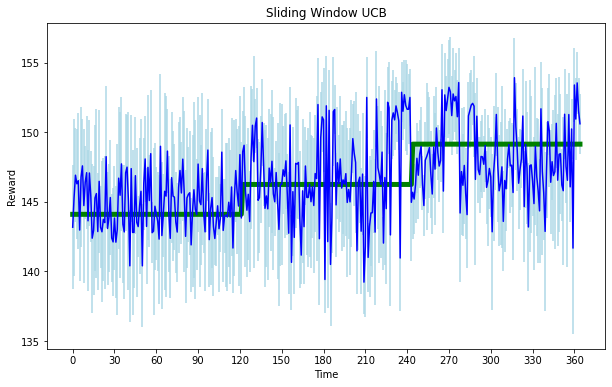

<Figure size 720x432 with 0 Axes>

In [346]:

plt.figure(figsize=(10, 6))  # Specify the width and height in inches

time_periods = range(len(SW_mean_rewards_per_round))

for t in time_periods:
    mean = SW_mean_rewards_per_round[t]
    std_dev = SW_std_dev_rewards_per_round[t]
    plt.vlines(t, mean - std_dev, mean + std_dev, color='lightblue')


plt.plot(time_periods, optimum_means, color='green', linestyle='-', linewidth=5)
plt.plot(time_periods, SW_mean_rewards_per_round, color='blue', linestyle='-')



plt.xlabel('Time')
plt.ylabel('Reward')
plt.title('Sliding Window UCB')

plt.xticks(time_periods[::30])

plt.figure(figsize=(10, 6))

plt.show()

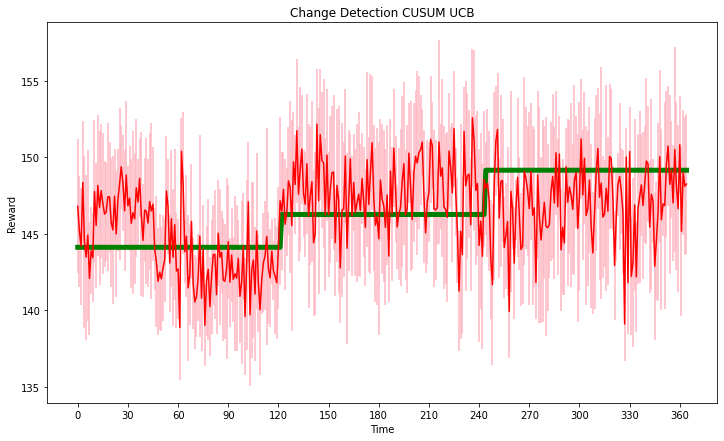

<Figure size 720x432 with 0 Axes>

In [347]:
plt.figure(figsize=(12, 7))  # Specify the width and height in inches


time_periods = range(len(CUSUM_mean_rewards_per_round))

for t in time_periods:
    mean = CUSUM_mean_rewards_per_round[t]
    std_dev = CUSUM_std_dev_rewards_per_round[t]
    plt.vlines(t, mean - std_dev, mean + std_dev, color='lightpink')


plt.plot(time_periods, optimum_means, color='green', linestyle='-', linewidth=5)
plt.plot(time_periods, CUSUM_mean_rewards_per_round, color='red', linestyle='-')




plt.xlabel('Time')
plt.ylabel('Reward')
plt.title('Change Detection CUSUM UCB')

plt.xticks(time_periods[::30])

plt.figure(figsize=(10, 6))

plt.show()

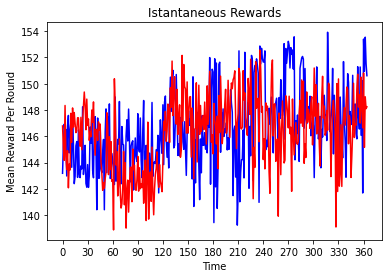

<Figure size 720x432 with 0 Axes>

In [348]:

time_periods = range(len(SW_mean_rewards_per_round))

plt.plot(time_periods, SW_mean_rewards_per_round, color='blue', linestyle='-', label = "SW_UCB")
plt.plot(time_periods, CUSUM_mean_rewards_per_round, color="red",linestyle="-", label = "CD_UCB")

plt.xlabel('Time')
plt.ylabel('Mean Reward Per Round')
plt.title('Istantaneous Rewards')

plt.xticks(time_periods[::30])

plt.figure(figsize=(10, 6))

plt.show()


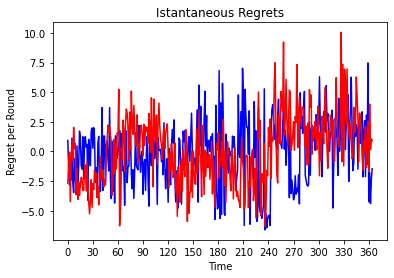

<Figure size 720x432 with 0 Axes>

In [349]:
time_periods = range(len(SW_mean_rewards_per_round))

plt.plot(time_periods, [x - y for x, y in zip(optimum_means, SW_mean_rewards_per_round)], color='blue', linestyle='-', label = "SW_UCB")
plt.plot(time_periods, [x - y for x, y in zip(optimum_means, CUSUM_mean_rewards_per_round)], color="red",linestyle="-", label = "CD_UCB")

plt.xlabel('Time')
plt.ylabel('Regret per Round')
plt.title('Istantaneous Regrets')

plt.xticks(time_periods[::30])

plt.figure(figsize=(10, 6))

plt.show()


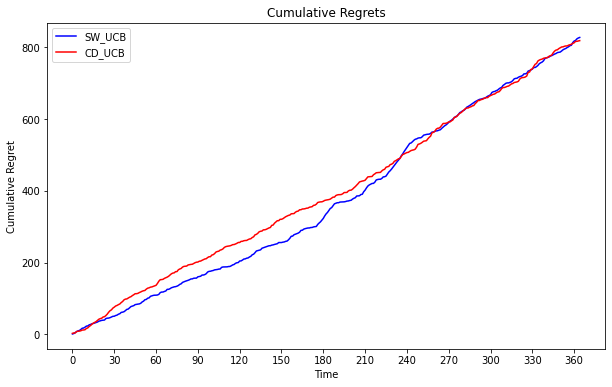

<Figure size 720x432 with 0 Axes>

In [350]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))  # Specify the width and height in inches



SW_cumulative_regret = [sum([abs(x - y) for x, y in zip(optimum_means[:t+1], SW_mean_rewards_per_round[:t+1])]) for t in time_periods]
CD_cumulative_regret = [sum([abs(x - y) for x, y in zip(optimum_means[:t+1], CUSUM_mean_rewards_per_round[:t+1])]) for t in time_periods]

plt.plot(time_periods, SW_cumulative_regret, color='blue', linestyle='-', label="SW_UCB")
plt.plot(time_periods, CD_cumulative_regret, color="red", linestyle="-", label="CD_UCB")

plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regrets')

plt.xticks(time_periods[::30])
plt.legend()

plt.figure(figsize=(10, 6))
plt.show()
